In [1]:
from systemclass import SNAIL,SNAILC,SNAIL_sweep,SNAILC_sweep,Cavity
import numpy as np
from qutip import *
import matplotlib.pyplot as plt

In [4]:
EJ = 70*2*np.pi
EC = 0.177*2*np.pi
beta = 0.12
ng = 0
ncut = 100
flux = 0.48
N = 3
dims = 6

# truncated_dim:int = 6
snail = SNAIL(EJ,EC,beta,ng,ncut,flux,N,dims)

omega_c1 = 7*2*np.pi
g_int1 = 0.15*2*np.pi
dimc1 = 4
trunc1 = dims * dimc1
cavity1 = Cavity(omega_c1,g_int1,dimc1)

# omega_c2 = 3*2*np.pi
# g_int2 = 0.15*2*np.pi
# dimc2 = 100
# trunc2 = dims*dimc2
# cavity2 = Cavity(omega_c2,g_int2,dimc2)

In [5]:
flux_values = np.linspace(0.42, 0.44, 100)
Hss = []
charge_ops = []
snail_freqs = []
snail_anhs = []
snail_freqs2 = []
for flux in flux_values:
    snail_back = SNAIL(EJ,EC,beta,ng,ncut,flux,N,dims)
    snail_anhs.append(snail_back.anh)
    H, op = snail_back.spectrum_charge()
    snail_freqs2.append(H[2,2]/2/np.pi)
    snailc =  SNAILC(snail_back, cavity1, trunc1)
    snailc.parameters()
    Hs , charge_op = snailc.dressed_H, snailc.dressed_charge
    energy = np.diag(Hs)
    Hss.append(Hs)
    index = np.argmin(np.abs(energy - snail_back.omegas* np.ones(len(energy))))
    snail_freqs.append(energy[index])
    charge_ops.append(charge_op)

In [6]:
def find_best_b_and_k(a, B, omega):
    min_diff = float('inf')  # Initialize with a very large number
    best_b = None
    best_k = None

    # Iterate over each element in B
    for b in B:
        # Iterate over each k in the range [-1000, 1000]
        for k in range(-1000, 1001):  # 1001 is used to include 1000 in the range
            diff = abs(a - (b + k * omega))
            # Update min_diff and best_b if a smaller difference is found
            if diff < min_diff:
                min_diff = diff
                best_b = b
                best_k = k

    return best_b, best_k, min_diff

In [21]:
import qutip as qt  
def find_optimal_k(A, B, D):
    # Define a large initial minimum difference
    min_diff = float('inf')
    optimal_k = None
    
    # Iterate over a range of possible k values
    # The range can be adjusted based on expected size of k or other insights you have about your problem
    for k in range(-1000, 1000):
        # Calculate the difference for this value of k
        diff = abs(A - (B + k * D))
        
        # If this is the smallest difference we've found so far, update min_diff and optimal_k
        if diff < min_diff:
            min_diff = diff
            optimal_k = k
            
    return optimal_k
# Function to calculate overlap (you might use inner product, fidelity, etc.)
def calculate_overlap(state1, state2):
    return abs((state1.dag() * state2))**2
def floquet_spec(Hs,Hc, omega, A,omegas):
#     Hs[0][0] = Hs[0][0]+Hs[1][1]
#     Hs[1][1] = Hs[1][1]+Hs[1][1]
    energy = np.diag(Hs)
    indexs1 = np.argmin(np.abs(energy - omegas * np.ones(len(energy))))
    indexc1 = np.argmin(np.abs(energy - omega_c1 * np.ones(len(energy))))
    indexc2 = np.argmin(np.abs(energy - 2 * omega_c1 * np.ones(len(energy))))
    indexsc = np.argmin(np.abs(energy - (omegas+omega_c1) * np.ones(len(energy))))
    indexs2 = np.argmin(np.abs(energy - (2*omegas) * np.ones(len(energy))))
    Hs = Qobj(Hs)
    
    Hc = Qobj(Hc)
    args = {'w': omega}
    T = (2*np.pi)/omega
    H = [Hs,  [Hc, lambda t, args: A*np.cos(args['w']*t)],] 
    options = Options(nsteps=100000)  # Increasing nsteps to 10000, adjust as needed
    f_modes, f_energies = floquet_modes(H, T, args, True, options=options) 
    basis_states = [qt.basis(trunc1, 0),qt.basis(trunc1, indexs1),qt.basis(trunc1,indexc1),qt.basis(trunc1,indexc2),qt.basis(trunc1,indexsc)
                   ,qt.basis(trunc1,indexsc),qt.basis(trunc1,indexs2)]
    
    # Initialize a list to hold the indices of the Floquet states with the maximum overlap for each basis state
    max_overlap_indices = [-1] * 7
    max_overlaps = [0] * 7
    # Loop over each Floquet state
    for f_index, f_state in enumerate(f_modes):
        # Loop over each basis state
        for b_index, b_state in enumerate(basis_states):
            # Calculate the overlap
            overlap = calculate_overlap(f_state, b_state)

            # If this is the maximum overlap for this basis state, store the index
            if overlap > max_overlaps[b_index]:
                max_overlaps[b_index] = overlap
                max_overlap_indices[b_index] = f_index
    energyg = f_energies[max_overlap_indices[0]]/2/np.pi

    energys1 = f_energies[max_overlap_indices[1]]/2/np.pi
    k = find_optimal_k(omega_c1/2/np.pi, energys1, omega/2/np.pi)
    energys1 = energys1 + k*omega/2/np.pi - energyg
    
    
    energyc1 = f_energies[max_overlap_indices[2]]/2/np.pi
    k = find_optimal_k(omega_c1/2/np.pi, energyc1, omega/2/np.pi)
    energyc1 = energyc1 + k*omega/2/np.pi - energyg
    
    energysc = f_energies[max_overlap_indices[4]]/2/np.pi
    k = find_optimal_k((omega_c1+omegas)/2/np.pi, energysc, omega/2/np.pi)
    starkshift = energysc - energyg + k*omega/2/np.pi - energyc1 - energys1
    
    energyc2 = f_energies[max_overlap_indices[3]]/2/np.pi
    k = find_optimal_k(2*omega_c1/2/np.pi, energyc2, omega/2/np.pi)
    energyc2 = energyc2 +k*omega/2/np.pi
    
    selfkerr = energyc2-energyg - 2*energyc1
    
    energys2 = f_energies[max_overlap_indices[5]]/2/np.pi
    
    k = find_optimal_k(2*omegas/2/np.pi, energys2, omega/2/np.pi)
    energys2 = energys2 + k*omega/2/np.pi - energyg
#     print(f_energies[max_overlap_indices[1]],f_energies[max_overlap_indices[0]])
    return energyc1, starkshift, selfkerr,energys2 ,energys1

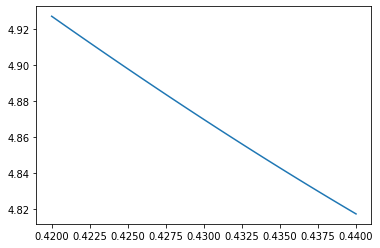

In [22]:
plt.plot(flux_values,np.array(snail_freqs)/2/np.pi)

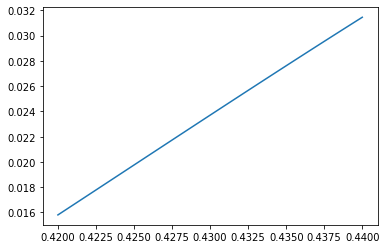

In [23]:
plt.plot(flux_values,np.array(snail_anhs)/2/np.pi)

In [97]:
omegas = 4.83*2*np.pi
omegac = 7*2*np.pi
delta = 0.1*2*np.pi
omega = (omegas )
A = 0.005*2*np.pi
floquet_results = []
for i in range(len(flux_values)):
    floquet_results.append(floquet_spec(Hss[i],charge_ops[i], omega, A,snail_freqs[i]))

In [98]:
floquet_results = np.array(floquet_results)

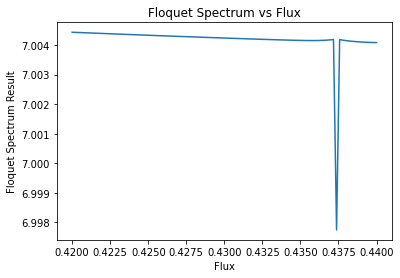

In [99]:
floquet_results = np.array(floquet_results)
# Plotting
plt.plot(flux_values, floquet_results[:,0])
# plt.plot(flux_values, -(floquet_results/2/np.pi)[:,4]+(floquet_results/2/np.pi)[:,7])
plt.xlabel('Flux')
plt.ylabel('Floquet Spectrum Result')
plt.title('Floquet Spectrum vs Flux')
# plt.ylim(7.0049,7.00496)
plt.show()

In [11]:
## import numpy as np
import matplotlib.pyplot as plt
import scipy as sci
from cosmatrix import cosm,expm_pade
expm = expm_pade
from autograd.extend import primitive, defvjp
from qutip import *
def annihilation(dim):
    return np.diag(np.sqrt(np.arange(1,dim)),1)
def creation(dim):
    return np.diag(np.sqrt(np.arange(1,dim)),-1)
def SNAIL_H(phi_ex,beta,N,Ej,Ec):
    phi_ex = 2*np.pi*phi_ex
    def Us_min(phi_ex):
        def U_s(phi): 
            return (-beta*np.cos(phi-phi_ex)-N*np.cos((phi)/N))
        phi_min = sci.optimize.minimize(U_s,0).x
        return phi_min
    
    def phi_minde(ans, phi_ex):
        def phi_minde_vjp(g):
            c2 = beta*np.cos(ans - phi_ex) + 1/N*np.cos(ans/N)
            return g*beta*np.cos(ans - phi_ex)/c2
        return phi_minde_vjp

    phi_min = Us_min(phi_ex)
    # potential expansion around minimum
    c2 = beta*np.cos(phi_min - phi_ex) + 1/N*np.cos(phi_min/N)
    omega_s = np.sqrt(8*c2*Ej*Ec)
    phi_zpf = np.power(2*Ec/(Ej*c2),1/4)
    g2 = Ej*phi_zpf**2*c2/2
    sdim = 10
    s = annihilation(sdim)
    sd = creation(sdim)
    x2 = np.matmul(s+sd,s+sd)
    c3 = (N**2-1)/N**2*np.sin(phi_min/N)
    g3 = Ej*phi_zpf**3*c3/3/2
    c4 = -beta*np.cos(phi_min-phi_ex) -1/N**3*np.cos(phi_min/N)

    g4 = Ej*phi_zpf**4*c4/4/3/2
    Hs = omega_s * np.matmul(sd,s)+(
        - Ej*(beta*cosm(phi_zpf*(s+sd)+(phi_min-phi_ex)*np.identity(sdim))
        + N*cosm((phi_zpf*(s+sd)+phi_min*np.identity(sdim))/N))- g2*x2)
    energy,U = np.linalg.eigh(Hs)
    for i in range(U.shape[1]):
        if U[i, i] < 0:
            U[:, i] *= -1
    U_dag = np.conjugate(U.transpose())
    
    Hs = Hs
    
    return Hs-energy[0]*np.identity(sdim),-1j*(s-sd),phi_zpf,c2

In [12]:
def sort(energies,U,H):
    diagonal_elements = np.diag(H)

    # Find the index of the closest diagonal element for each eigenvalue
    closest_indices = np.argmin(abs(energies[:, np.newaxis] - diagonal_elements), axis=1)

    # Sort energies and U according to the indices of closest diagonal elements
    sorted_energies = energies[np.argsort(closest_indices)]
    U = U[:, np.argsort(closest_indices)]
    return sorted_energies,U

In [13]:
from scipy.sparse.linalg import expm
from scipy.linalg import logm
def floquet_spec3(omega,A,phi_ex,omega_c,g_int):
    beta = 0.12
    N = 3
    Ej = 70*2*np.pi
    Ec = 0.177*2*np.pi
    
    H0,v,phi_zpf,c2 = SNAIL_H(phi_ex,beta,N,Ej,Ec)
    g_int = g_int*c2**0.25
    
    energies,U=np.linalg.eig(H0)
    energies = energies - energies[0]*np.ones(len(energies))
    sorted_indices = np.argsort(energies)

    U = U[:, sorted_indices]
    Ud = U.transpose().conjugate()
    
    energies = np.sort(energies)
    omega_s = energies[1]
    anh = energies[2] - 2* energies[1]
    dims = 10
    s = annihilation(dims)
    sd = creation(dims)
    delta = (omega_s-omega)

    cdim = 6
    c = annihilation(cdim)
    cd = creation(cdim)
    Ic = np.identity(cdim)
    Is = np.identity(dims)
    s = np.kron(s,Ic)
    sd = np.kron(sd,Ic)
    c = np.kron(Is,c)
    cd = np.kron(Is,cd)
    H = omega_s*sd@s  + omega_c * cd@c +g_int*((s+sd)@(cd+c))
    energies,U=np.linalg.eig(H)
        # Get the diagonal elements of H
    sorted_energies,U = sort(energies,U,H)
    Ud = U.transpose().conjugate()
    Hnl = Ud@(anh/2*sd@sd@s@s)@U
    H =  omega_s*sd@s  + omega_c * cd@c +g_int*((s+sd)@(cd+c))+(anh/2*sd@sd@s@s)

    
    delta = (omega_c-omega_s)
    p=8*g_int**4*omega_c*omega_s**2/(omega_c**6-3*omega_c**4*omega_s**2+3*omega_c**2*omega_s**4-omega_s**6)
#     H = (omega_s-g_int**2/delta + g_int**2/(omega_c+omega_s)+p)*sd@s+(omega_c+g_int**2/delta - g_int**2/(omega_c+omega_s)-p)*cd@c+Hnl
    lam = g_int/(-delta)
    sorted_energies = sorted_energies - sorted_energies[0]*np.ones(len(sorted_energies))
    omega_sp = sorted_energies[np.argmin(np.abs(sorted_energies - omega_s))]
    omega_cp = sorted_energies[1]
    eta = A/2/phi_zpf/2
    delta = (omega_sp-omega)
    
    s = annihilation(dims)
    sd = creation(dims)
    c = annihilation(cdim)
    cd = creation(cdim)
    Ic = np.identity(cdim)
    Is = np.identity(dims)
    
    
    Hs = delta*sd@s +(anh/2*sd@sd@s@s)+ eta*(s+sd)
    energies,U = np.linalg.eig(Hs)
    energies,U = sort(energies,U,Hs)
    Ud = U.transpose().conjugate()
    
    ele = [1 / (delta + anh* (n)) for n in range(0,dims)]
    diagonal_matrix = np.diag(np.ravel(np.array(ele)))
    result = -1j*eta*(sd@diagonal_matrix + diagonal_matrix@s)
    U = (np.identity(dims)+result)
    Ud = U.transpose().conjugate()
    
    energies = np.diag(Ud@Hs@U)
    energies,U = sort(energies,U,Hs)
    Ud = U.transpose().conjugate()
#     Hs =  (delta+4*eta**2/(delta+anh))*sd@s +(anh/2*sd@sd@s@s)+ eta*(s+sd)
    term = Ud@sd@s@U
    upper_diag0 = np.diag(np.diag(term, k=0), k=0)  # Rebuild the matrix with modified diagonal
    upper_diag1 = np.diag(np.diag(term, k=1), k=1)
    lower_diag1 = np.diag(np.diag(term, k=-1), k=-1)
    upper_diag2 = np.diag(np.diag(term, k=2), k=2)
    lower_diag2 = np.diag(np.diag(term, k=-2), k=-2)
    H = np.kron((delta+4*eta**2/(anh+delta))*sd@s +(anh/2*sd@sd@s@s),Ic) + np.kron(Is,omega_cp*cd@c)+np.kron(2*lam**2*anh*(upper_diag1+lower_diag1),cd@c)
    energies,U = np.linalg.eig(H)
    a = np.zeros(len(H))
    a[0] = 1

    # Compute the overlaps (absolute values of the first elements of the columns of U)
    overlaps = np.abs(U[0, :])**2

    # Find the index of the maximum overlap
    max_overlap_index = np.argmax(overlaps)
#     if max(overlaps)<=0.8:
#         return 0,overlaps[0]**2,overlaps[1]**2
    energies = omega_cp+2*lam**2*anh*(eta**2/delta**2+(2*eta**2/(delta*(2*delta+anh)))**2)
    return np.real(energies/2/np.pi)
6.009191037837764
floquet_spec3(4.9*2*np.pi,0.005*2*np.pi,0.425,7*2*np.pi,0.15*2*np.pi)

array([7.00459567])

In [19]:
from scipy.sparse.linalg import expm
from scipy.linalg import logm
def floquet_spec2(omega,A,phi_ex,omega_c,g_int):
    beta = 0.12
    N = 3
    Ej = 70*2*np.pi
    Ec = 0.177*2*np.pi
    
    H0,v,phi_zpf,c2 = SNAIL_H(phi_ex,beta,N,Ej,Ec)
    g_int = g_int*c2**0.25
    
    energies,U=np.linalg.eig(H0)
    energies = energies - energies[0]*np.ones(len(energies))
    sorted_indices = np.argsort(energies)

    U = U[:, sorted_indices]
    Ud = U.transpose().conjugate()
    
    energies = np.sort(energies)
    omega_s = energies[1]
    anh = energies[2] - 2* energies[1]
    dims = 10
    s = annihilation(dims)
    sd = creation(dims)
    delta = (omega_s-omega)

    cdim = 8
    c = annihilation(cdim)
    cd = creation(cdim)
    Ic = np.identity(cdim)
    Is = np.identity(dims)
    s = np.kron(s,Ic)
    sd = np.kron(sd,Ic)
    c = np.kron(Is,c)
    cd = np.kron(Is,cd)
    H = omega_s*sd@s  + omega_c * cd@c +g_int*((s+sd)@(cd+c))
    energies,U=np.linalg.eig(H)
        # Get the diagonal elements of H
    sorted_energies,U = sort(energies,U,H)
    Ud = U.transpose().conjugate()
    Hnl = Ud@(anh/2*sd@sd@s@s)@U
    H =  omega_s*sd@s  + omega_c * cd@c +g_int*((s+sd)@(cd+c))+(anh/2*sd@sd@s@s)

    
    delta = (omega_c-omega_s)
#     p=8*g_int**4*omega_c*omega_s**2/(omega_c**6-3*omega_c**4*omega_s**2+3*omega_c**2*omega_s**4-omega_s**6)
#     H = (omega_s-g_int**2/delta + g_int**2/(omega_c+omega_s)+p)*sd@s+(omega_c+g_int**2/delta - g_int**2/(omega_c+omega_s)-p)*cd@c+Hnl
    lam = g_int/(-delta)
    sorted_energies = sorted_energies - sorted_energies[0]*np.ones(len(sorted_energies))
    omega_sp = sorted_energies[np.argmin(np.abs(sorted_energies - omega_s))]
    omega_cp = sorted_energies[1]
    eta = A/2/phi_zpf/2
    delta = (omega_sp-omega)
    
    s = annihilation(dims)
    sd = creation(dims)
    c = annihilation(cdim)
    cd = creation(cdim)
    Ic = np.identity(cdim)
    Is = np.identity(dims)
    Hs = delta*sd@s +(anh/2*sd@sd@s@s)+ eta*(s+sd)

    H = np.kron(Hs,Ic) + np.kron(Is,omega_cp*cd@c)+np.kron(2*lam**2*anh*sd@s,cd@c)
    energies,U = np.linalg.eig(H)
    a = np.zeros(len(H))
    a[0] = 1

    # Compute the overlaps (absolute values of the first elements of the columns of U)
    overlaps = np.abs(U[0, :])**2

    # Find the index of the maximum overlap
    max_overlap_index = np.argmax(overlaps)
#     if max(overlaps)<=0.8:
#         return 0,overlaps[0]**2,overlaps[1]**2
    energies = energies - energies[max_overlap_index]*np.ones(len(energies))
    return np.real(energies[np.argmin(np.abs(energies - omega_cp))])/2/np.pi
floquet_spec2(4.9*2*np.pi,0.005*2*np.pi,0.426,7*2*np.pi,0.15*2*np.pi)

7.004330461392692

In [20]:
## 0.00640639/-8.25531096e-04

In [21]:
x_values = flux_values  # 0.4, 0.43

# Calculate the results for each x value
results = [floquet_spec3(omega, A, x,omega_c1, 0.15 * 2 * np.pi)  for x in x_values]



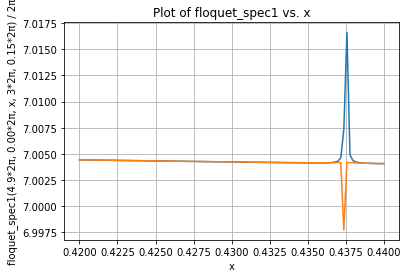

In [22]:
### Plot the results
plt.plot(x_values, np.array(results))
plt.plot(x_values, floquet_results[:,0])
plt.xlabel('x')
plt.ylabel('floquet_spec1(4.9*2π, 0.00*2π, x, 3*2π, 0.15*2π) / 2π')
plt.title('Plot of floquet_spec1 vs. x')
plt.grid(True)
# plt.ylim(7.0048,7.005)
plt.show()

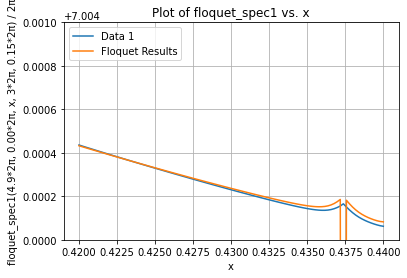

In [26]:

# Calculate the results for each x value
results = [floquet_spec2(omega, A, x, omega_c1, 0.15 * 2 * np.pi)  for x in x_values]

### Plot the results
plt.plot(x_values, np.array(results), label='Data 1')
plt.plot(x_values, floquet_results[:,0], label='Floquet Results')
plt.xlabel('x')
plt.ylabel('floquet_spec1(4.9*2π, 0.00*2π, x, 3*2π, 0.15*2π) / 2π')
plt.title('Plot of floquet_spec1 vs. x')
plt.grid(True)
plt.ylim(7.004,7.005)

# Create a second y-axis
# Optional: Add a legend
plt.legend(loc='upper left')

# Show the plot
plt.show()